In [3]:
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

from stellargraph.mapper import DirectedGraphSAGENodeGenerator
from stellargraph.layer import DirectedGraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model,Input

import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import pandas as pd
from sklearn.decomposition import PCA
import numpy as np
import math
from sklearn import preprocessing,model_selection

from collections import defaultdict

from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.python.ops.numpy_ops import np_config
#np_config.enable_numpy_behavior()

In [4]:
def load_my_data():
    #controlsDK = pd.read_csv('controls_counts.tsv', sep='\t', header=0).dropna()
    #z_score normalized data, the other espression matrices are normalized with another method
    controlsDK = pd.read_csv('locicero_brca_normalizzato/locicero_brca_data_norm_2.tsv', sep='\t', header=0).dropna()
    controlsDK.index = controlsDK.index.astype(int)
    controlsDK = controlsDK.sort_index()
    tumorDK = pd.read_csv('locicero_brca_tumor/locicero_brca_data_tumor_zscores.txt', sep='\t', header=0).dropna()
    tumorDK.index = tumorDK.index.astype(int)
    tumorDK = tumorDK.sort_index()
    tmp = pd.read_csv('metapathway_kegg_genes/gene_edges.tsv', sep='\t', header=0)
    # creating adjacency list
    def add_edges(currentDict,N,M):
        N_set = set()
        if str(N) in currentDict:
            N_set = currentDict[str(N)]
        N_set.add(str(M))
        currentDict[str(N)] = N_set
    
    outAdjacencyListMetapathways = defaultdict(set)
    inAdjacencyListMetapathways = defaultdict(set)
    for index, row in tmp.iterrows():
        add_edges(outAdjacencyListMetapathways,row["start"],row["end"])
        add_edges(inAdjacencyListMetapathways,row["end"],row["start"])
        
    # controls with features
    boolGenesWithFeatureSources = tmp["start"].map(lambda value: value in controlsDK.index)
    boolGenesWithFeatureTargets = tmp["end"].map(lambda value: value in controlsDK.index)
    boolGenesWithFeature = boolGenesWithFeatureSources & boolGenesWithFeatureTargets

    # tumors with features
    boolGenesTumorWithFeatureSources = tmp["start"].map(lambda value: value in tumorDK.index)
    boolGenesTumorWithFeatureTargets = tmp["end"].map(lambda value: value in tumorDK.index)
    boolGenesTumorWithFeature = boolGenesTumorWithFeatureSources & boolGenesTumorWithFeatureTargets

    #genesWithNoFeatures = [100653049, 9103, 2831, 100528032, 100132285, 3810, 3806, 3808,390441, 3118, 3126, 3125, 390271, 26595, 81399, 432355, 100996746, 504190, 504191, 140, 504189, 729759, 100532736,107080638, 414062, 102723407, 6019, 3803, 107181291, 102723555, 102723532, 107987545, 102800317, 100505767, 341568, 112268384, 100533105, 106821730, 388372, 105369274, 100271849, 57292, 390432]
    tmpGeneEdges = pd.read_csv('metapathway_kegg_genes/gene_edges.tsv', sep='\t', header=0).rename(columns={'start': 'source', 'end': 'target'}) 
    #geneEdgesWithNoFeatures = pd.concat(
    #    [geneEdgesWithNoFeatures[geneEdgesWithNoFeatures['source'].isin(genesWithNoFeatures)], 
    #     geneEdgesWithNoFeatures[geneEdgesWithNoFeatures['target'].isin(genesWithNoFeatures)]]
    #     )
    #geneEdgesWithNoFeatures = geneEdgesWithNoFeatures.drop_duplicates()
    geneEdgesWithNoFeatures = tmpGeneEdges[~boolGenesWithFeature]
    geneEdgesWithNoFeaturesTumor = tmpGeneEdges[~boolGenesTumorWithFeature]

    # indexes of control genes with features and not
    indexesGenesWithFeatures = controlsDK.index
    indexesGenesWithNoFeatures = pd.concat([ geneEdgesWithNoFeatures[~geneEdgesWithNoFeatures["source"].isin(controlsDK.index)]["source"] , geneEdgesWithNoFeatures[~geneEdgesWithNoFeatures["target"].isin(controlsDK.index)]["target"] ]).drop_duplicates()


    # indexes of tumor genes with features and not
    indexesGenesTumorWithFeatures = tumorDK.index
    indexesGenesTumorWithNoFeatures = pd.concat([ geneEdgesWithNoFeaturesTumor[~geneEdgesWithNoFeaturesTumor["source"].isin(tumorDK.index)]["source"] , geneEdgesWithNoFeaturesTumor[~geneEdgesWithNoFeaturesTumor["target"].isin(tumorDK.index)]["target"] ]).drop_duplicates()

    #filtering genes with no features
    #geneEdges = geneEdges[~geneEdges['source'].isin(genesWithNoFeatures)]
    #geneEdges = geneEdges[~geneEdges['target'].isin(genesWithNoFeatures)]
    geneEdges = tmpGeneEdges[boolGenesWithFeature]
    geneEdgesTumor = tmpGeneEdges[boolGenesTumorWithFeature]
    pathways = pd.read_csv('metapathway_kegg_genes/pathways.tsv', sep='\t', header=0)
    return inAdjacencyListMetapathways,outAdjacencyListMetapathways,controlsDK,tumorDK, geneEdges,geneEdgesTumor,geneEdgesWithNoFeatures,geneEdgesWithNoFeaturesTumor,indexesGenesWithFeatures,indexesGenesWithNoFeatures,indexesGenesTumorWithFeatures,indexesGenesTumorWithNoFeatures, pathways

In [5]:
inAdjacencyListMetapathways,outAdjacencyListMetapathways,controlsDK,tumorDK,geneEdges,geneEdgesTumor,geneEdgesWithNoFeatures,geneEdgesWithNoFeaturesTumor,indexGeneEdgesWithFeatures,indexGeneEdgesWithNoFeatures,indexesGenesTumorWithFeatures,indexesGenesTumorWithNoFeatures,pathways = load_my_data()

In [6]:
annotationTumors = pd.read_csv('brca_clinical_stagemod.txt', sep='\t', header=0) #with NA values for subtype
subtypeAnnotationLists = annotationTumors.groupby('SUBTYPE')['ID'].apply(list)
tumorStageAnnotationLists = annotationTumors.groupby('AJCC_PATHOLOGIC_TUMOR_STAGE')['ID'].apply(list)
tumorDKwithAnnotation = tumorDK.copy()
tumorDK = tumorDK.drop(["Hugo_Symbol","Entrez_Gene_Id"],axis=1)

#subtypes
basalExprMatrix = tumorDK.filter(subtypeAnnotationLists[0])
her2ExprMatrix = tumorDK.filter(subtypeAnnotationLists[1])
lumAExprMatrix = tumorDK.filter(subtypeAnnotationLists[2])
lumBExprMatrix = tumorDK.filter(subtypeAnnotationLists[3])
normalExprMatrix = tumorDK.filter(subtypeAnnotationLists[4])
#stage
stageIExprMatrix = tumorDK.filter(tumorStageAnnotationLists[0])
stageIIExprMatrix = tumorDK.filter(tumorStageAnnotationLists[1])
stageIIIExprMatrix = tumorDK.filter(tumorStageAnnotationLists[2])
stageIVExprMatrix = tumorDK.filter(tumorStageAnnotationLists[3])
stageXExprMatrix = tumorDK.filter(tumorStageAnnotationLists[4])

# Preliminary definitions

In [7]:
@tf.function
def difference_of_edge_genes_embeddingGCN(edges,y_pred):
    #gene1 = tf.gather(y_pred,edges[0])
    #gene2 = tf.gather(y_pred,edges[1])
    gene1 = y_pred[0][edges[0]]
    gene2 = y_pred[0][edges[1]]
    return tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)

tfControls = tf.constant(controlsDK,tf.float32)
#difference_of_edge_genes_embedding(tensorEdgesTest[3],tfControls)

In [8]:
## TESTING the computation of c
def testC(gene1,gene2,inList,outList):
    source1AdjSet = outList[str(gene1)]
    source2AdjSet = outList[str(gene2)]
    source1PredSet = inList[str(gene1)]
    source2PredSet = inList[str(gene2)]
    #c = (len(source1AdjSet) + len(source1PredSet) + len(source2AdjSet) + len(source2PredSet) -
    #     (len(source1AdjSet.union(source2AdjSet)) + len(source1PredSet.union(source2PredSet) ))) 
    c = ( (len(source1AdjSet.union(source2AdjSet)) + len(source1PredSet.union(source2PredSet) )) + 
         abs(len(source1AdjSet)-len(source2AdjSet)) + abs(len(source1PredSet)-len(source2PredSet)) )
    return c

In [9]:
def precomputeCostantsTensor(tensorEdges,inAdjacencyListMetapathways,outAdjacencyListMetapathways,divider):
    constantsList = []
    for i in range(0,tensorEdges.shape[0]):
        c = testC(tensorEdges[i][0].numpy(),
                tensorEdges[i][1].numpy(),inAdjacencyListMetapathways,outAdjacencyListMetapathways) / divider
        constantsList.append(c)
    return constantsList,tf.constant(constantsList,tf.float32)

In [10]:

@tf.function( experimental_relax_shapes=True)
def difference_of_genes_embedding_weightedGCN(node1,node2,y_pred,c):
    # dividing by max degree to get a small value could be a better option
    gene1 = y_pred[0][node1]
    gene2 = y_pred[0][node2]
    return c*tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)


@tf.function
def difference_of_genes_embeddingGCN(node1,node2,y_pred):
    # dividing by max degree to get a small value could be a better option
    gene1 = y_pred[0][node1]
    gene2 = y_pred[0][node2]
    tmp = tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)
    return tmp

In [11]:

    
@tf.function
def genes_loss(y_true, y_pred, edges):
    loss = tf.constant(0, tf.float32)
    #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
    for row in edges:
        loss = loss + difference_of_edge_genes_embeddingGCN(row,y_pred)
    return loss
    #return tf.reduce_sum(partials)

#@tf.function
def genes_loss_with_closure(edges):
    def loss_out(y_true, y_pred):
        loss = tf.constant(0, tf.float32)
        #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
        for row in edges:
            loss = loss + difference_of_edge_genes_embeddingGCN(row,y_pred)
        return loss
    return loss_out


def genes_loss_with_closure_weighted(edges,inAdjacencyListMetapathways,outAdjacencyListMetapathways):
    def loss_out(y_true, y_pred):
        loss = tf.constant(0, tf.float32)
        #partials = tf.map_fn(lambda edge: difference_of_edge_genes_embedding(edge,y_pred),  tensorEdgesTest)  
        for row in range(0,edges.shape[0]):
            c = testC(edges[row][0],edges[row][1],inAdjacencyListMetapathways,outAdjacencyListMetapathways)
            loss = loss + difference_of_edge_genes_embedding_weightedGCN(edges[row],y_pred,c)
        return loss
    return loss_out


def optimized_loss(tensorEdgesTest,tfControls,constantTensor):
    test1 = tf.map_fn(lambda edge:difference_of_genes_embedding(edge[0],edge[1],tfControls),tensorEdgesTest,fn_output_signature=tf.float32)
    test2 = tf.math.multiply(test1,constantTensor) 
    return tf.reduce_sum(test2 )

def optimized_loss(tensorEdgesTest,constantTensor):
    @tf.function
    def loss_out(y_true, y_pred):
        test1 = tf.map_fn(lambda edge:difference_of_genes_embeddingGCN(edge[0],edge[1],y_pred),tensorEdgesTest,fn_output_signature=tf.float32)
        test2 = tf.math.multiply(test1,constantTensor) 
        return tf.reduce_sum(test2 )
    return loss_out

In [12]:
@tf.function
def difference_of_edge_genes_embeddingGRAPHSAGE(edges,y_pred):
    #gene1 = tf.gather(y_pred,edges[0])
    #gene2 = tf.gather(y_pred,edges[1])
    gene1 = y_pred[edges[0]]
    gene2 = y_pred[edges[1]]
    return tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)

#@tf.function
def genes_loss_with_closure(edges):
    def loss_out(y_true, y_pred):
        loss = tf.constant(0, tf.float32)
        for row in edges:
            loss = loss + difference_of_edge_genes_embeddingGRAPHSAGE(row,y_pred)
        return loss
    return loss_out

#@tf.function
def testLoss(edge):
    def loss_out(y_true, y_pred):
        gene1 = y_pred[edge[0]]
        gene2 = y_pred[edge[1]]
        return tf.sqrt(tf.reduce_sum(tf.square(gene1 - gene2)) + 1.0e-12)
    return loss_out

def optimized_lossGNN(tensorEdgesTest,constantTensor):
    @tf.function
    def loss_out(y_true, y_pred): 
        return tf.reduce_sum(tf.math.multiply(tf.map_fn(lambda edge:difference_of_edge_genes_embeddingGRAPHSAGE(edge,y_pred),tensorEdgesTest,fn_output_signature=tf.float32),constantTensor) )
    return loss_out



#test_gen = generator.flow(test_subjects.index, test_subjects)


### preliminary steps

In [16]:
indexOfGenesTumor = dict()

for i in range(0,len(tumorDK.index)):
    indexOfGenesTumor[tumorDK.index[i]] = i

tensorEdgesTumor = tf.constant(geneEdgesTumor,tf.int32)
tensorEdgesTestTumor = tf.map_fn(lambda row: tf.map_fn(lambda element:indexOfGenesTumor[element.numpy()],tf.gather(row, [0, 1]).numpy()) ,tensorEdgesTumor)  # take only edges with no weight

**using the full dataset for the constant vector used in the loss function for both the reduced dataset(with less columns) and the full dataset since the final product is the same**

In [17]:
tfTumor = tf.constant(tumorDK,tf.float32)
#difference_of_edge_genes_embedding(tensorEdgesTest[3],tfControls)
maxDegreeTumor = 0

for gene in list(tumorDK.index):
    if(len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)]) > maxDegreeTumor):
        maxDegreeTumor = len(inAdjacencyListMetapathways[str(gene)]) + len(outAdjacencyListMetapathways[str(gene)])

precompConstantListTumor,constantTensorTumor = precomputeCostantsTensor(tensorEdgesTumor,inAdjacencyListMetapathways,outAdjacencyListMetapathways,maxDegreeTumor)
constantTensorTumor

<tf.Tensor: shape=(17264,), dtype=float32, numpy=
array([0.24344024, 0.35568514, 0.35568514, ..., 0.20991254, 0.20991254,
       0.20991254], dtype=float32)>

## Genes embeddings for **LumA** tumors (all patients)

In [18]:
directedGraphTumor = sg.StellarDiGraph(lumAExprMatrix ,geneEdgesTumor)
print(directedGraphTumor.info())

batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]

generatorTumorLumA = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

trainGenTumorfinal = generatorTumorLumA.flow(lumAExprMatrix.index, lumAExprMatrix)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorLumA, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=lumAExprMatrix.shape[1], activation="softmax")(x_outTumorfinal)

modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()


checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesLumAFull.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 498
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 5, 498)]     0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 5, 498)]     0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 10, 498)]    0           []           

In [19]:
#modelTumorfinal.load_weights(checkpointPathTumorfinal)  ## IMP

In [20]:

with tf.device('/CPU:0'):
    history = modelTumorfinal.fit(
        trainGenTumorfinal, epochs=50, 
        #validation_data=test_gen,
        batch_size=batch_sizeTumor,
        verbose=2, 
        shuffle=False,
        callbacks=[cp_callback]
    )

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAFull.ckpt
1/1 - 247s - loss: 19.7078 - acc: 0.0014 - 247s/epoch - 247s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAFull.ckpt
1/1 - 245s - loss: 16.4726 - acc: 0.0019 - 245s/epoch - 245s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAFull.ckpt
1/1 - 246s - loss: 14.0390 - acc: 0.0014 - 246s/epoch - 246s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAFull.ckpt
1/1 - 239s - loss: 11.9436 - acc: 0.0015 - 239s/epoch - 239s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAFull.ckpt
1/1 - 241s - loss: 10.8305 - acc: 0.0015 - 241s/epoch - 241s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumAFull.ckpt
1/1 - 246s - loss: 8.9306 - acc: 0.0023 - 246s/epoch - 246s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesLum

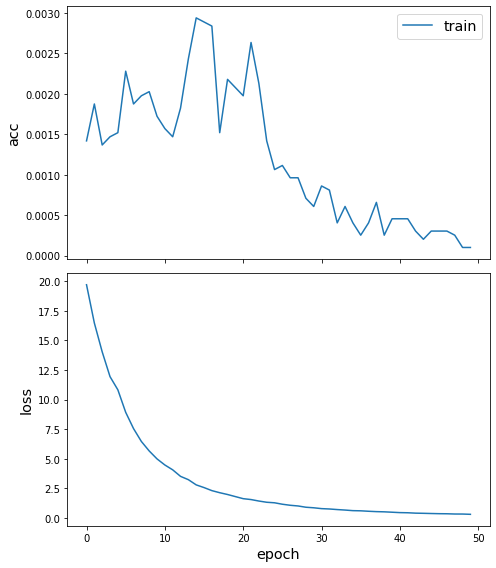

In [21]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

sg.utils.plot_history(history)

### generazione embedding per tumor LumA

In [22]:
all_mapper = generatorTumorLumA.flow(lumAExprMatrix.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorLumA = pd.DataFrame(all_predictions, index =lumAExprMatrix.index,columns =lumAExprMatrix.columns)

In [23]:
genesEmbeddingsTumorLumA

,TCGA-3C-AALK,TCGA-4H-AAAK,TCGA-5L-AAT0,TCGA-A1-A0SD,TCGA-A1-A0SE,TCGA-A1-A0SF,TCGA-A1-A0SG,TCGA-A1-A0SH,TCGA-A1-A0SJ,TCGA-A1-A0SQ,...,TCGA-S3-AA12,TCGA-S3-AA14,TCGA-UL-AAZ6,TCGA-V7-A7HQ,TCGA-W8-A86G,TCGA-WT-AB41,TCGA-WT-AB44,TCGA-XX-A899,TCGA-XX-A89A,TCGA-Z7-A8R5
2,0.001917,0.001800,0.002266,0.002033,0.002262,0.002068,0.001794,0.001934,0.002229,0.001888,...,0.002098,0.001784,0.002200,0.001956,0.002185,0.001970,0.002014,0.002245,0.002113,0.002244
3,0.001913,0.001800,0.002269,0.002030,0.002257,0.002065,0.001795,0.001933,0.002229,0.001884,...,0.002099,0.001791,0.002185,0.001958,0.002184,0.001962,0.002015,0.002241,0.002101,0.002244
7,0.001920,0.001798,0.002263,0.002028,0.002267,0.002071,0.001795,0.001931,0.002226,0.001889,...,0.002102,0.001782,0.002195,0.001963,0.002187,0.001971,0.002014,0.002240,0.002114,0.002244
8,0.001920,0.001798,0.002264,0.002028,0.002267,0.002071,0.001795,0.001931,0.002226,0.001889,...,0.002101,0.001782,0.002195,0.001963,0.002187,0.001971,0.002014,0.002240,0.002114,0.002244
10,0.001920,0.001798,0.002264,0.002028,0.002267,0.002071,0.001795,0.001931,0.002227,0.001889,...,0.002101,0.001782,0.002195,0.001963,0.002187,0.001971,0.002014,0.002240,0.002114,0.002244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20526,0.001920,0.001801,0.002262,0.002030,0.002270,0.002072,0.001793,0.001934,0.002223,0.001888,...,0.002102,0.001783,0.002198,0.001963,0.002185,0.001970,0.002016,0.002241,0.002111,0.002245
20527,0.001920,0.001798,0.002264,0.002028,0.002267,0.002071,0.001795,0.001931,0.002226,0.001889,...,0.002101,0.001782,0.002195,0.001963,0.002187,0.001971,0.002014,0.002240,0.002114,0.002244
20528,0.001920,0.001798,0.002264,0.002028,0.002267,0.002071,0.001795,0.001931,0.002226,0.001889,...,0.002101,0.001782,0.002195,0.001963,0.002187,0.001971,0.002014,0.002240,0.002114,0.002244
20529,0.001920,0.001798,0.002263,0.002028,0.002267,0.002071,0.001795,0.001931,0.002226,0.001889,...,0.002101,0.001782,0.002195,0.001963,0.002187,0.001971,0.002014,0.002240,0.002114,0.002244


### visualizzazione embeddings LumA

<AxesSubplot:>

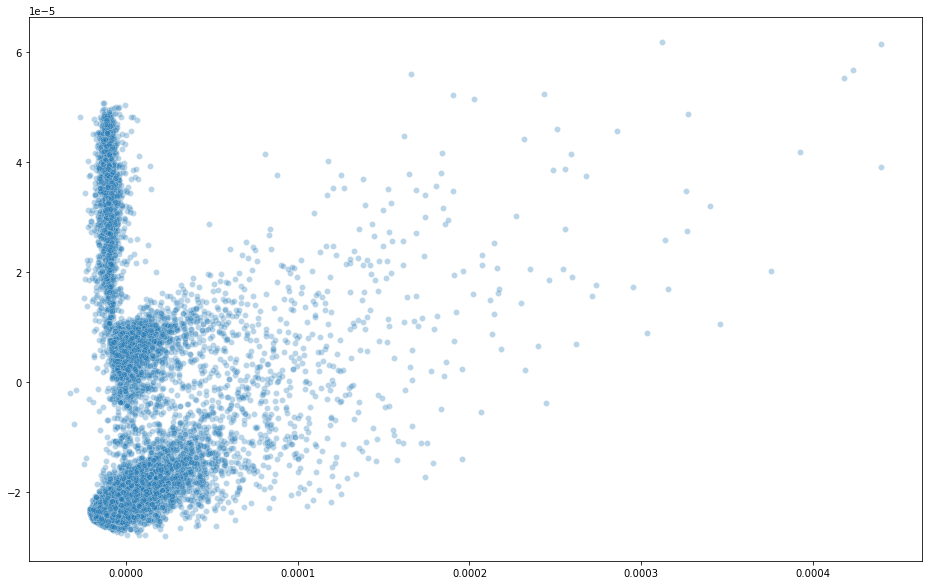

In [24]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorLumA)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

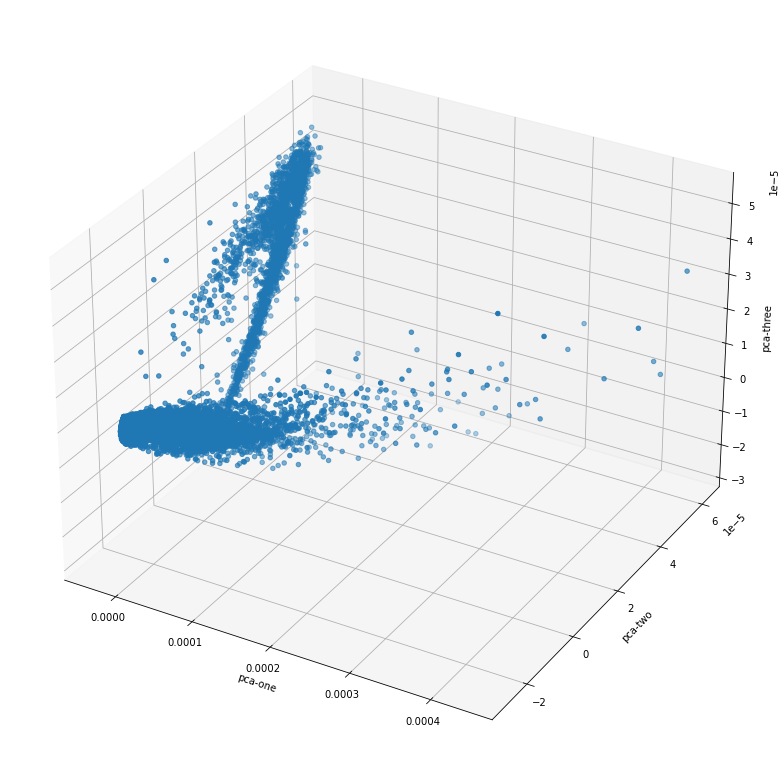

In [25]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **LumB** tumors

In [40]:
directedGraphTumor = sg.StellarDiGraph(lumBExprMatrix ,geneEdgesTumor)
print(directedGraphTumor.info())

batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]

generatorTumorLumB = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

trainGenTumorfinal = generatorTumorLumB.flow(lumBExprMatrix.index, lumBExprMatrix)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorLumB, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=lumBExprMatrix.shape[1], activation="softmax")(x_outTumorfinal)

modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()


checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesLumBFull.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 197
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 5, 197)]     0           []                               
                                                                                                  
 input_45 (InputLayer)          [(None, 5, 197)]     0           []                               
                                                                                                  
 input_46 (InputLayer)          [(None, 10, 197)]    0           []           

In [41]:
modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [29]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBFull.ckpt
1/1 - 24s - loss: 46.9828 - acc: 0.0046 - 24s/epoch - 24s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBFull.ckpt
1/1 - 23s - loss: 42.8595 - acc: 0.0046 - 23s/epoch - 23s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBFull.ckpt
1/1 - 22s - loss: 37.5760 - acc: 0.0046 - 22s/epoch - 22s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBFull.ckpt
1/1 - 22s - loss: 33.8322 - acc: 0.0047 - 22s/epoch - 22s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBFull.ckpt
1/1 - 23s - loss: 30.2424 - acc: 0.0045 - 23s/epoch - 23s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBFull.ckpt
1/1 - 23s - loss: 27.0592 - acc: 0.0045 - 23s/epoch - 23s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorGenesLumBFull.ckpt
1/1 - 

In [52]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

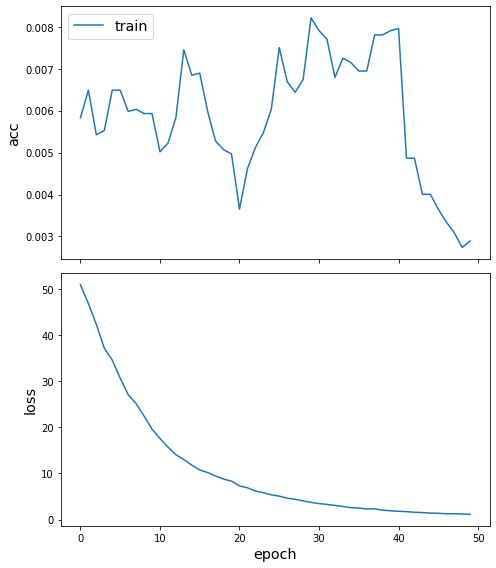

In [53]:
sg.utils.plot_history(history)

### generazione embedding per tumor LumB

In [43]:
all_mapper = generatorTumorLumB.flow(lumBExprMatrix.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorLumB = pd.DataFrame(all_predictions, index =lumBExprMatrix.index,columns =lumBExprMatrix.columns)

In [44]:
genesEmbeddingsTumorLumB

,TCGA-3C-AALJ,TCGA-5T-A9QA,TCGA-A1-A0SI,TCGA-A1-A0SN,TCGA-A2-A04R,TCGA-A2-A04Y,TCGA-A2-A0CW,TCGA-A2-A0D4,TCGA-A2-A0EY,TCGA-A2-A0SV,...,TCGA-EW-A1OY,TCGA-EW-A1OZ,TCGA-EW-A1P0,TCGA-EW-A2FW,TCGA-GM-A2DO,TCGA-LL-A5YM,TCGA-LL-A7T0,TCGA-S3-A6ZF,TCGA-S3-AA17,TCGA-Z7-A8R6
2,0.004929,0.004287,0.005279,0.005790,0.004517,0.004829,0.004780,0.005395,0.005719,0.004668,...,0.004281,0.005620,0.005680,0.005428,0.005811,0.005511,0.005404,0.004329,0.004364,0.005162
3,0.004895,0.004167,0.005219,0.005766,0.004549,0.004841,0.004763,0.005377,0.005682,0.004686,...,0.004263,0.005592,0.005710,0.005415,0.005805,0.005498,0.005364,0.004344,0.004343,0.005084
7,0.004930,0.004266,0.005257,0.005799,0.004523,0.004850,0.004769,0.005393,0.005727,0.004653,...,0.004280,0.005616,0.005680,0.005422,0.005810,0.005518,0.005390,0.004344,0.004370,0.005158
8,0.004932,0.004267,0.005257,0.005797,0.004524,0.004848,0.004767,0.005392,0.005727,0.004653,...,0.004281,0.005617,0.005680,0.005422,0.005810,0.005518,0.005393,0.004343,0.004371,0.005158
10,0.004926,0.004267,0.005259,0.005800,0.004520,0.004848,0.004770,0.005394,0.005731,0.004656,...,0.004279,0.005616,0.005677,0.005424,0.005805,0.005518,0.005390,0.004348,0.004366,0.005156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20526,0.004971,0.004258,0.005247,0.005825,0.004537,0.004813,0.004786,0.005345,0.005729,0.004615,...,0.004244,0.005621,0.005712,0.005407,0.005781,0.005547,0.005402,0.004316,0.004423,0.005140
20527,0.004928,0.004268,0.005257,0.005798,0.004522,0.004850,0.004768,0.005394,0.005728,0.004655,...,0.004281,0.005616,0.005677,0.005423,0.005809,0.005518,0.005392,0.004345,0.004368,0.005159
20528,0.004931,0.004262,0.005256,0.005795,0.004523,0.004847,0.004766,0.005391,0.005726,0.004653,...,0.004282,0.005617,0.005680,0.005423,0.005811,0.005516,0.005393,0.004343,0.004371,0.005156
20529,0.004932,0.004268,0.005257,0.005797,0.004523,0.004848,0.004768,0.005393,0.005728,0.004652,...,0.004281,0.005617,0.005679,0.005422,0.005810,0.005517,0.005393,0.004344,0.004372,0.005159


### visualizzazione embeddings LumB

<AxesSubplot:>

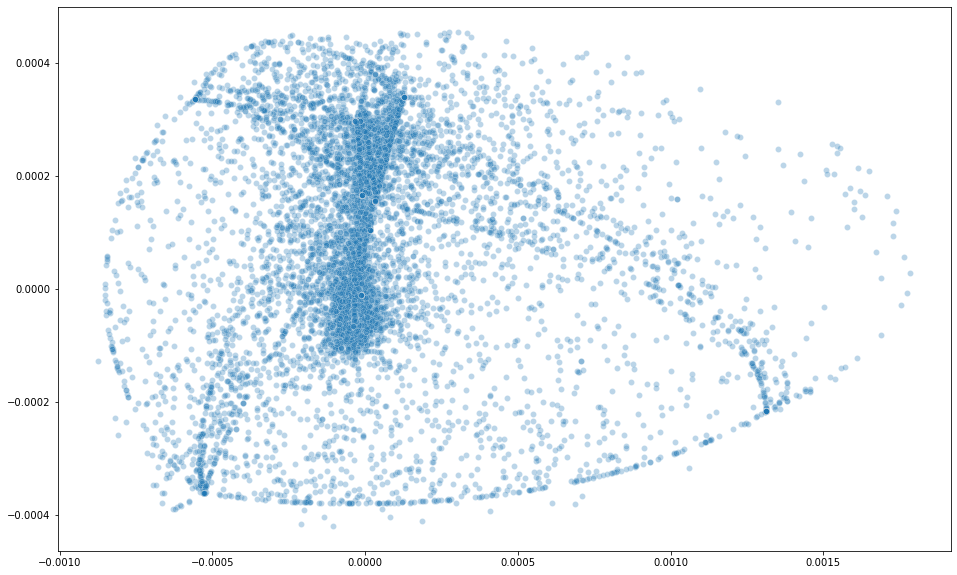

In [45]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorLumB)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

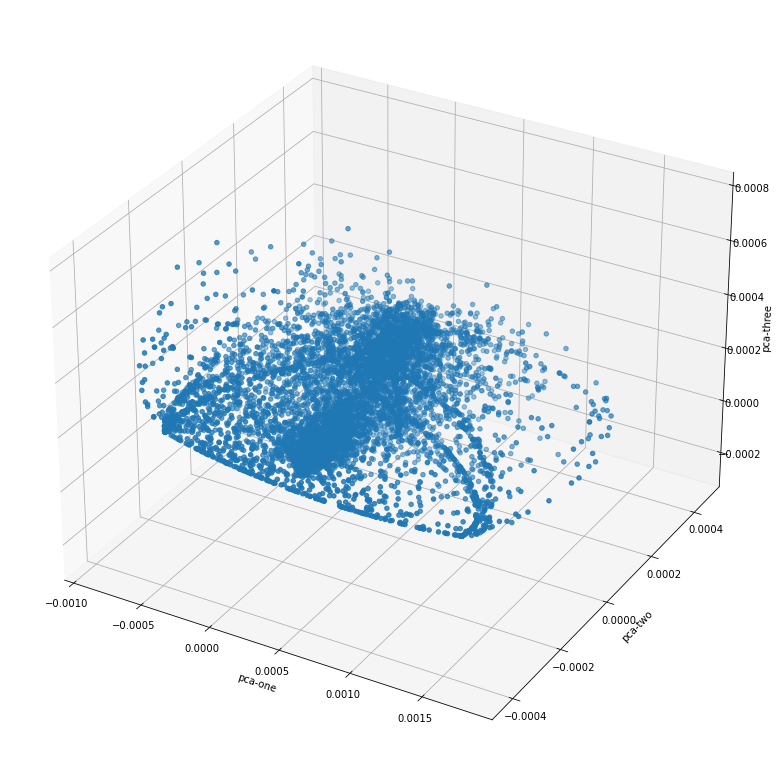

In [46]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

## Genes embeddings for **Stage III** tumors

In [30]:
directedGraphTumor = sg.StellarDiGraph(stageIIIExprMatrix ,geneEdgesTumor)
print(directedGraphTumor.info())

batch_sizeTumor = int(tumorDK.shape[0])
#batch_sizeTumor = tumorDK.shape[0]
in_samples = [5, 2]
out_samples = [5, 2]

generatorTumorStageIII = DirectedGraphSAGENodeGenerator(directedGraphTumor, batch_sizeTumor, in_samples, out_samples)

trainGenTumorfinal = generatorTumorStageIII.flow(stageIIIExprMatrix.index, stageIIIExprMatrix)

graphsage_modelTumorfinal = DirectedGraphSAGE(
    layer_sizes=[32, 32], generator=generatorTumorStageIII, bias=False, dropout=0.5,
)

x_inpTumorfinal, x_outTumorfinal = graphsage_modelTumorfinal.in_out_tensors()
predictionTumorfinal = layers.Dense(units=stageIIIExprMatrix.shape[1], activation="softmax")(x_outTumorfinal)

modelTumorfinal = Model(inputs=x_inpTumorfinal, outputs=predictionTumorfinal)
modelTumorfinal.compile(
    optimizer=optimizers.Adam(learning_rate=0.005),
    loss=optimized_lossGNN(tensorEdgesTest=tensorEdgesTestTumor,constantTensor=constantTensorTumor),
    #loss=genes_loss_with_closure(edges=tensorEdgesTest),
    #loss = testLoss([0,1]),
    metrics=["acc"]
)

#test_gen = generator.flow(test_subjects.index, test_subjects)
modelTumorfinal.summary()


checkpointPathTumorfinal = "model_checkpoints/GRAPHSAGEtumorGenesStageIIIFull.ckpt"
checkpointDirTumorfinal = os.path.dirname(checkpointPathTumorfinal)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpointPathTumorfinal,
                                                 save_weights_only=True,
                                                 verbose=1)

StellarDiGraph: Directed multigraph
 Nodes: 19727, Edges: 17264

 Node types:
  default: [19727]
    Features: float32 vector, length 249
    Edge types: default-default->default

 Edge types:
    default-default->default: [17264]
        Weights: range=[-1, 1], mean=0.68165, std=0.7317
        Features: none
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_37 (InputLayer)          [(None, 5, 249)]     0           []                               
                                                                                                  
 input_38 (InputLayer)          [(None, 5, 249)]     0           []                               
                                                                                                  
 input_39 (InputLayer)          [(None, 10, 249)]    0           []           

In [70]:
#modelTumorfinal.load_weights(checkpointPathTumorfinal)

In [31]:
history = modelTumorfinal.fit(
    trainGenTumorfinal, epochs=50, 
    #validation_data=test_gen,
    batch_size=batch_sizeTumor,
    verbose=2, 
    shuffle=False,
    callbacks=[cp_callback]
)

Epoch 1/50

Epoch 1: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIIIFull.ckpt
1/1 - 23s - loss: 35.8705 - acc: 0.0031 - 23s/epoch - 23s/step
Epoch 2/50

Epoch 2: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIIIFull.ckpt
1/1 - 20s - loss: 32.6957 - acc: 0.0034 - 20s/epoch - 20s/step
Epoch 3/50

Epoch 3: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIIIFull.ckpt
1/1 - 21s - loss: 29.0084 - acc: 0.0031 - 21s/epoch - 21s/step
Epoch 4/50

Epoch 4: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIIIFull.ckpt
1/1 - 21s - loss: 26.1723 - acc: 0.0035 - 21s/epoch - 21s/step
Epoch 5/50

Epoch 5: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIIIFull.ckpt
1/1 - 21s - loss: 22.9102 - acc: 0.0042 - 21s/epoch - 21s/step
Epoch 6/50

Epoch 6: saving model to model_checkpoints/GRAPHSAGEtumorGenesStageIIIFull.ckpt
1/1 - 20s - loss: 20.3172 - acc: 0.0041 - 20s/epoch - 20s/step
Epoch 7/50

Epoch 7: saving model to model_checkpoints/GRAPHSAGEtumorG

In [32]:
modelTumorfinal.save_weights(checkpointPathTumorfinal.format(epoch=0))

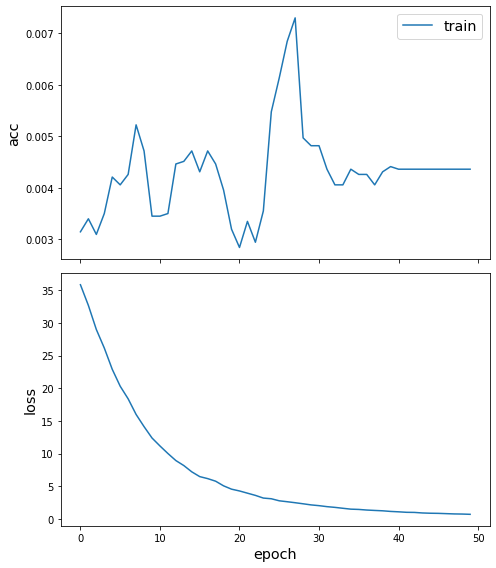

In [33]:
sg.utils.plot_history(history)

### generazione embedding per tumor Stage III

In [35]:
all_mapper = generatorTumorStageIII.flow(stageIIIExprMatrix.index)
all_predictions = modelTumorfinal.predict(all_mapper)
all_predictions = all_predictions.astype("float64")

genesEmbeddingsTumorStageIII = pd.DataFrame(all_predictions, index =stageIIIExprMatrix.index,columns =stageIIIExprMatrix.columns)

In [72]:
genesEmbeddingsTumorStageIII

,TCGA-BH-A1FJ,TCGA-A8-A06R,TCGA-E9-A249,TCGA-E9-A1NA,TCGA-EW-A2FW,TCGA-AR-A250,TCGA-A2-A0SW,TCGA-AC-A7VB,TCGA-BH-A202,TCGA-A8-A07L,...,TCGA-C8-A130,TCGA-EW-A1OX,TCGA-A8-A09I,TCGA-B6-A0IN,TCGA-AO-A1KP,TCGA-AO-A0JD,TCGA-E9-A2JS,TCGA-AN-A0AM,TCGA-A8-A076,TCGA-A8-A082
2,0.004976,0.006105,0.005124,0.006401,0.006509,0.005012,0.006533,0.005833,0.004993,0.004943,...,0.004959,0.005322,0.006580,0.005129,0.006787,0.005180,0.006327,0.005682,0.006623,0.006579
3,0.004956,0.006155,0.005104,0.006409,0.006514,0.005061,0.006502,0.005845,0.005020,0.004974,...,0.004987,0.005359,0.006559,0.005134,0.006817,0.005192,0.006309,0.005683,0.006600,0.006610
7,0.004959,0.006143,0.005095,0.006414,0.006537,0.005015,0.006511,0.005815,0.004997,0.004948,...,0.004941,0.005344,0.006580,0.005139,0.006778,0.005147,0.006351,0.005683,0.006614,0.006594
8,0.004960,0.006145,0.005095,0.006414,0.006535,0.005012,0.006513,0.005813,0.004996,0.004949,...,0.004941,0.005342,0.006581,0.005140,0.006778,0.005149,0.006353,0.005685,0.006614,0.006592
10,0.004958,0.006150,0.005097,0.006413,0.006529,0.005021,0.006506,0.005824,0.005003,0.004953,...,0.004952,0.005344,0.006574,0.005134,0.006789,0.005156,0.006340,0.005685,0.006607,0.006596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20526,0.004995,0.006148,0.005112,0.006423,0.006552,0.005020,0.006489,0.005865,0.005046,0.004923,...,0.005000,0.005379,0.006566,0.005079,0.006797,0.005148,0.006328,0.005660,0.006594,0.006599
20527,0.004960,0.006144,0.005095,0.006414,0.006536,0.005012,0.006513,0.005813,0.004996,0.004948,...,0.004941,0.005342,0.006580,0.005139,0.006778,0.005148,0.006353,0.005685,0.006614,0.006592
20528,0.004960,0.006144,0.005095,0.006414,0.006537,0.005012,0.006512,0.005814,0.004997,0.004948,...,0.004941,0.005343,0.006580,0.005139,0.006778,0.005147,0.006353,0.005684,0.006614,0.006593
20529,0.004964,0.006144,0.005098,0.006414,0.006536,0.005008,0.006509,0.005814,0.005000,0.004942,...,0.004946,0.005345,0.006580,0.005134,0.006777,0.005147,0.006355,0.005682,0.006612,0.006591


### visualizzazione embeddings LumB

<AxesSubplot:>

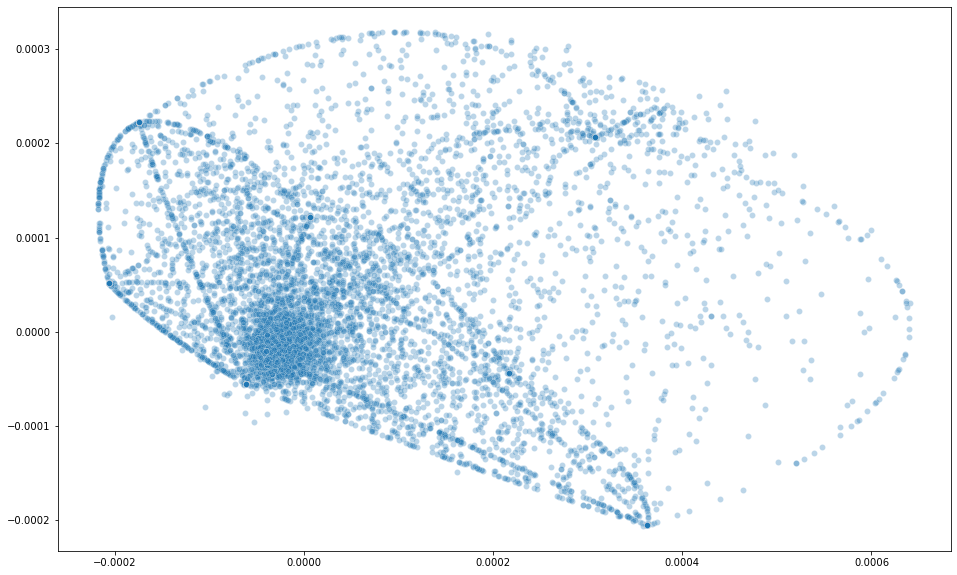

In [38]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(genesEmbeddingsTumorStageIII)
firstDim = pca_result[:,0]
secondDim = pca_result[:,1] 
thirdDim = pca_result[:,2]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x=firstDim, y=secondDim,
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

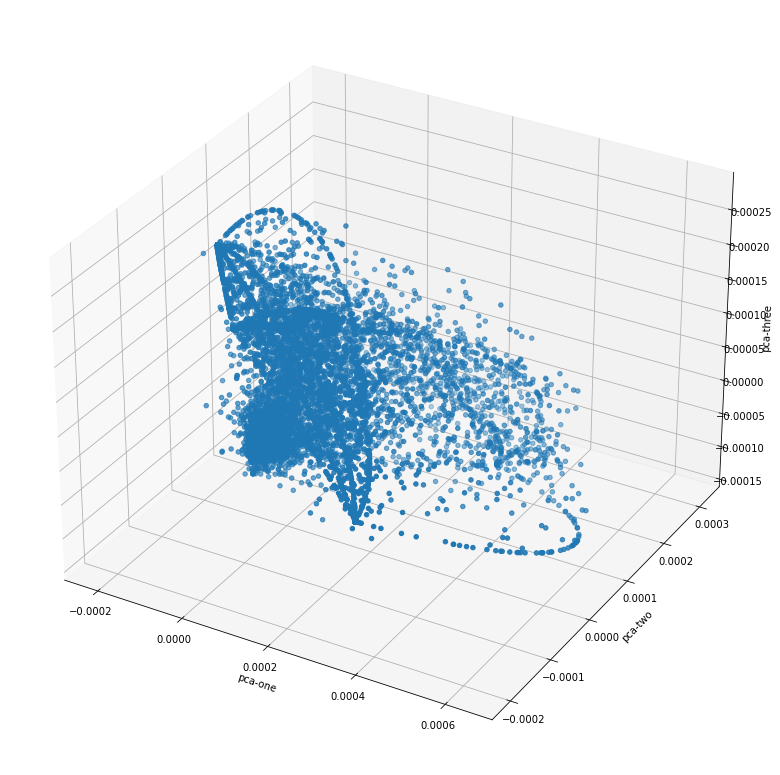

In [39]:
ax = plt.figure(figsize=(16,14)).gca(projection='3d')
ax.scatter(
    xs=firstDim, 
    ys=secondDim, 
    zs=thirdDim, 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()